<a href="https://colab.research.google.com/github/DForgard/cesarienne_a_lhopital/blob/main/cesarienne_a_lhopital.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# téléchargement du jeu de données (lien vers le fichier)
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00472/caesarian.csv.arff

--2022-07-16 09:49:39--  https://archive.ics.uci.edu/ml/machine-learning-databases/00472/caesarian.csv.arff
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1437 (1.4K) [application/x-httpd-php]
Saving to: ‘caesarian.csv.arff’

caesarian.csv.arff  100%[===================>]   1.40K  --.-KB/s    in 0s      

2022-07-16 09:49:40 (39.8 MB/s) - ‘caesarian.csv.arff’ saved [1437/1437]



In [38]:
# Césarienne à l'hôpital (page web complète): https://archive.ics.uci.edu/ml/datasets/Caesarian+Section+Classification+Dataset
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.metrics import accuracy_score
import re
import graphviz


In [3]:
# le fichier est dans le répertoire courant
filename = "caesarian.csv.arff"
# lire le dataframe
all_lines = []
with open(filename) as f:
 all_lines = f.readlines()


In [4]:
all_lines

['@relation caesarian\n',
 '\n',
 '\n',
 '\n',
 '\n',
 "@attribute 'Age' { 22,26,28,27,32,36,33,23,20,29,25,37,24,18,30,40,31,19,21,35,17,38 } \n",
 "@attribute 'Delivery number' { 1,2,3,4 }\n",
 "@attribute 'Delivery time' { 0,1,2 }\n",
 "@attribute 'Blood of Pressure' { 2,1,0 }\n",
 '\n',
 "@attribute 'Heart Problem' { 1,0 } \n",
 '@attribute Caesarian { 0,1 }\n',
 '\n',
 '\n',
 '@data\n',
 '\n',
 '\n',
 '22,1,0,2,0,0\n',
 '26,2,0,1,0,1\n',
 '26,2,1,1,0,0\n',
 '28,1,0,2,0,0\n',
 '22,2,0,1,0,1\n',
 '26,1,1,0,0,0\n',
 '27,2,0,1,0,0\n',
 '32,3,0,1,0,1\n',
 '28,2,0,1,0,0\n',
 '27,1,1,1,0,1\n',
 '36,1,0,1,0,0\n',
 '33,1,1,0,0,1\n',
 '23,1,1,1,0,0\n',
 '20,1,0,1,1,0\n',
 '29,1,2,0,1,1\n',
 '25,1,2,0,0,0\n',
 '25,1,0,1,0,0\n',
 '20,1,2,2,0,1\n',
 '37,3,0,1,1,1\n',
 '24,1,2,0,1,1\n',
 '26,1,1,1,0,0\n',
 '33,2,0,0,1,1\n',
 '25,1,1,2,0,0\n',
 '27,1,0,0,1,1\n',
 '20,1,0,2,1,1\n',
 '18,1,0,1,0,0\n',
 '18,1,1,2,1,1\n',
 '30,1,0,1,0,0\n',
 '32,1,0,2,1,1\n',
 '26,2,1,1,1,0\n',
 '25,1,0,0,0,0\n',
 '

In [5]:
# le fichier csv possède des lignes qui vont rendre sa lecture directe via panda impossible
# on itère sur les lignes afin de ne retenir que les lignes qui respectent un regex : 'nombre,nombre,nombre,nombre,nombre,nombre\n'
# on enlève alors le saut de ligne : "\n"
all_obs = [line.replace("\n","").split(",") for line  in all_lines if re.match('([\d,]+)\\n', line)]

In [6]:
# on constitue un dataframe à partir de la liste
df_caesarian = pd.DataFrame(all_obs, columns = ["Age",
                                               "Delivery number",
                                               "Delivery time",
                                               "Blood of Pressure",
                                               "Heart Problem",
                                               "Caesarian"])

In [9]:
df_caesarian.head()


,Age,Delivery number,Delivery time,Blood of Pressure,Heart Problem,Caesarian
0,22,1,0,2,0,0
1,26,2,0,1,0,1
2,26,2,1,1,0,0
3,28,1,0,2,0,0
4,22,2,0,1,0,1


In [10]:
# on se définit les colonnes d'intérêt : variable endogène /variable que l'on veut prédire
target_df = df_caesarian[["Caesarian"]].astype(int)

In [8]:
# colonne numérique
num_df = df_caesarian[["Age"]].astype(int)


In [22]:
# colonnes catégorielle
cat_df = df_caesarian[["Delivery number",
            "Delivery time",
            "Blood of Pressure",
            "Heart Problem"]].astype(int)

In [11]:
# nous allons convertir les colonnes catégorielles
# il n'existe pas de relation d'ordre pour des variables catégorielles
# il faut donc convertir le data frame en format large
cols = []
for col in ["Delivery number", 
            "Delivery time",
            "Blood of Pressure",
            "Heart Problem"]:

 col_dim = len(df_caesarian[col].unique())
 print(col_dim)
 cols += [f"{col}_{str(k)}" for k in range(col_dim)]

 print(f"the column: {col} will be transformed into : {col_dim} columns")

4
the column: Delivery number will be transformed into : 4 columns
3
the column: Delivery time will be transformed into : 3 columns
3
the column: Blood of Pressure will be transformed into : 3 columns
2
the column: Heart Problem will be transformed into : 2 columns


In [12]:
# les données ne sont pas à la même échelle
df_scaler = StandardScaler()

In [14]:
# on se limite aux colonnes à standardiser (le résultat est une numpy array)
np_num_col_scaled = df_scaler.fit_transform(num_df)

In [15]:
# la numpy array est transformée en dataframe
df_num_col_scaled = pd.DataFrame(np_num_col_scaled, columns= ["Age"])

In [17]:
# les données sont catégorielles
enc = OneHotEncoder(handle_unknown='ignore')

In [23]:
# convertit le résultat de matrice creuse (sparse) en matrice pleine (dense)
# (le résultat est une numpy array)
np_cat_columns_one_hot = enc.fit_transform(cat_df).todense()

In [24]:
# la numpy array est transformée en dataframe
df_cat_columns_one_hot = pd.DataFrame(np_cat_columns_one_hot, columns=cols)


In [25]:
# on concatène les colonnes numériques standardisées et les colonnes catégorielles encodées
master_df = pd.concat([df_num_col_scaled, df_cat_columns_one_hot, target_df], axis = 1)
master_df = master_df.sample(frac=1)

**Opération de Pruning**

In [26]:
# on sépare le jeu de données en (données d'entraînement et test)
data_train_caesarian, data_test_caesarian = train_test_split(master_df)

In [27]:
data_train_caesarian.shape

(60, 14)

In [28]:
data_test_caesarian.shape

(20, 14)

In [34]:
# jeu d'entraînement + étiquettes d'entraînement
X_train_caesarian = data_train_caesarian.drop(columns=["Caesarian"])
Y_train_caesarian = data_train_caesarian[["Caesarian"]]


In [29]:
# jeu de test +  étiquettes de test
X_test_caesarian  = data_test_caesarian.drop(columns=["Caesarian"])
Y_test_caesarian  = data_test_caesarian[["Caesarian"]]

In [30]:
from sklearn import tree
clf_dt_II = tree.DecisionTreeClassifier(criterion='gini',   # Mesure la qualité de la partition (impureté de Gini ou gain d'information).
                                 splitter='best',          # stratégie pour  partitionner à chaque noeud
                                 max_depth=100,            # peut être spécifiée pour réduire l'overfitting
                                 min_samples_split=2,      # peut être spécifiée pour réduire l'overfitting (définit la taille minimum pour initier une partition)
                                 min_samples_leaf=1,       # taille minimum d'un noeud terminal/feuille
                                 max_features=10,          # le nombre maximum d'attributs à considérer pour partitionner (ici nous avons 12 attributs)
                                 random_state=42,          # permet la reproductibilité des résultats
                                 max_leaf_nodes=None,      # peut limiter le nombre de noeuds terminaux (limite la largeur de l'arbre)
                                 min_impurity_decrease=0.0,# un noeud sera partitionné s’il y a une diminution de l'impureté (mesurée par l'indice de Gini)
                                 class_weight=None,        # à spécifier en cas de données non équilibrées
                                 ccp_alpha=0.0)            # à spécifier pour réduire l'overfitting (mécanisme de pruning)

**Entrainement du modèle**

In [35]:
#entrainement du modèle
clf_dt = tree.DecisionTreeClassifier()
clf_dt_II = clf_dt.fit(X_train_caesarian, Y_train_caesarian)
caesarian_predictions = clf_dt_II.predict(X_test_caesarian)

0.5


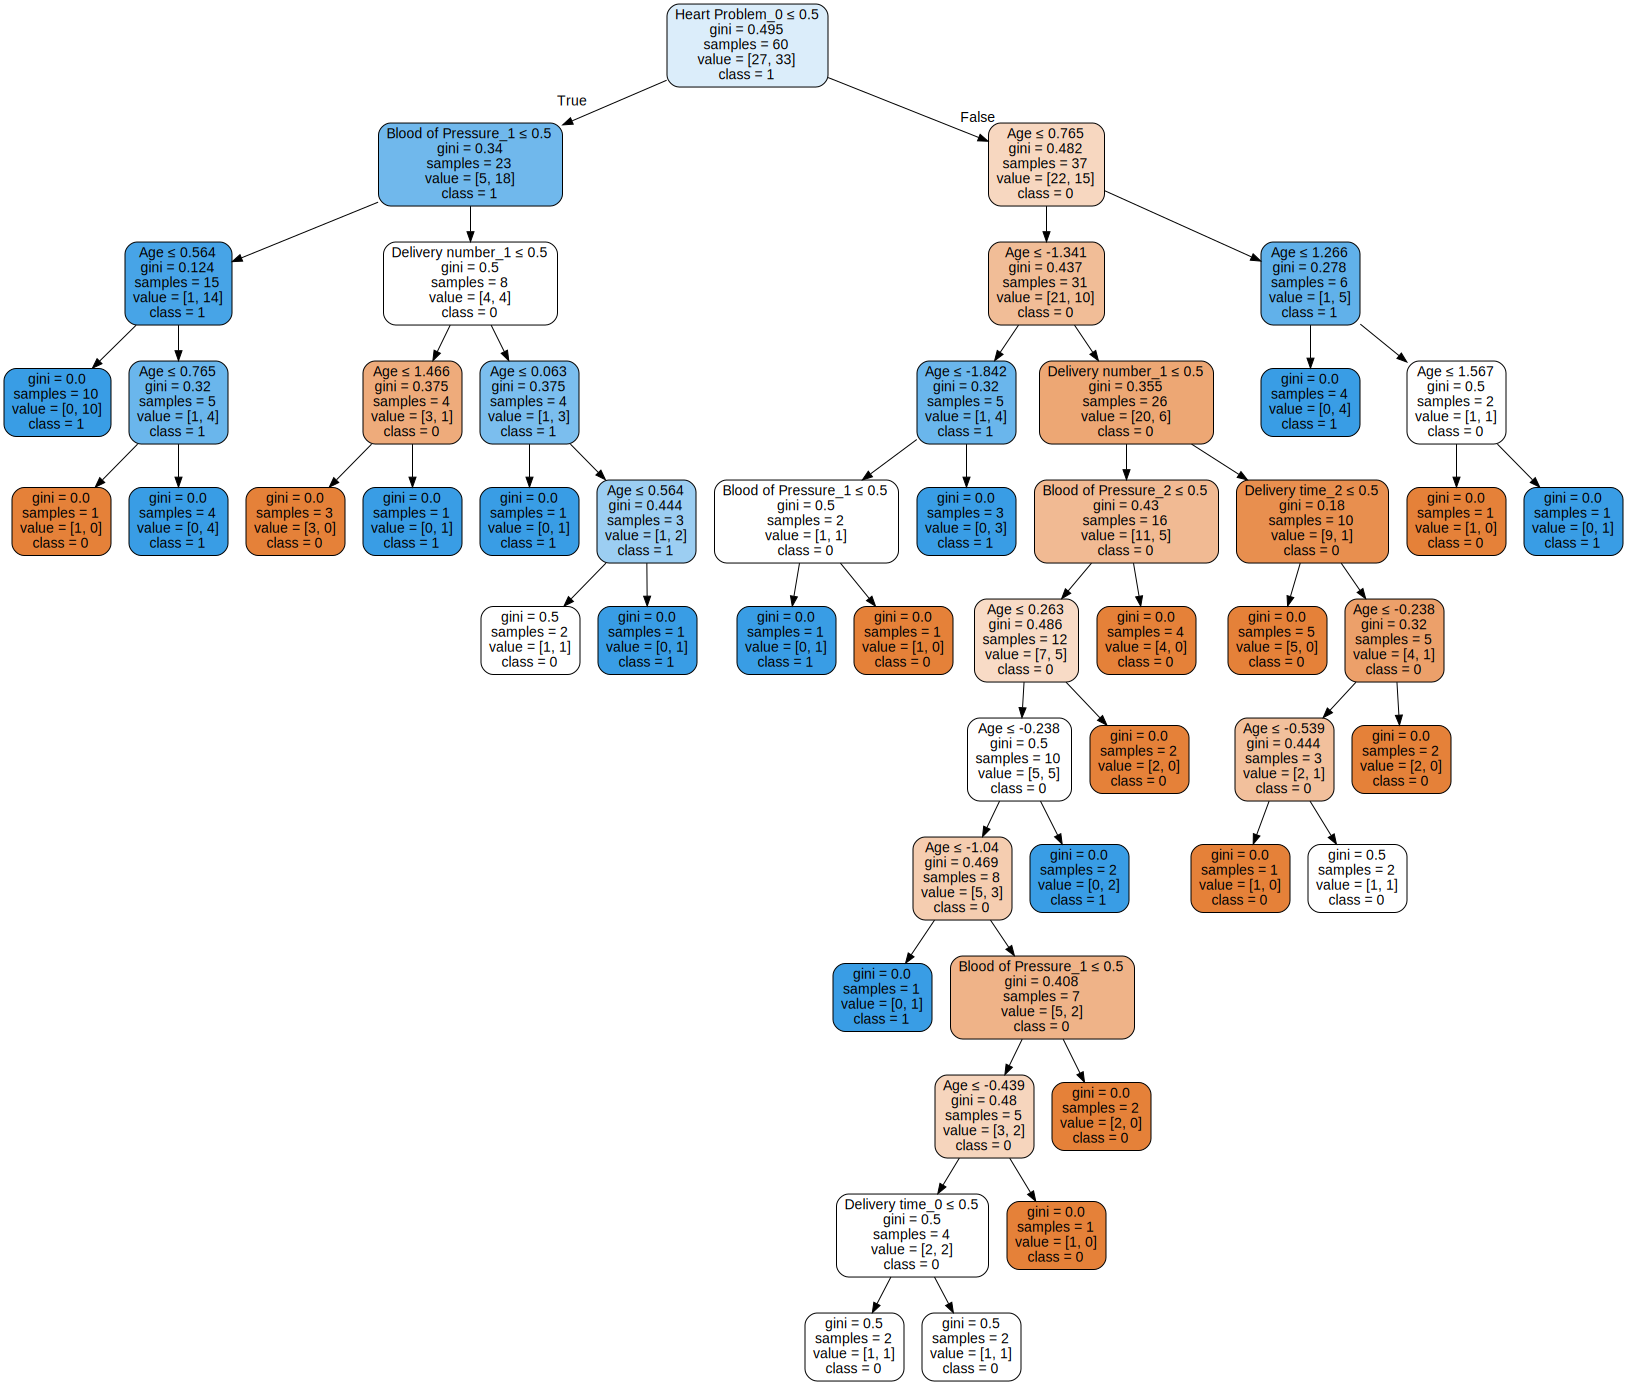

<Figure size 720x720 with 0 Axes>

In [39]:
# métrique
acc_score = accuracy_score(Y_test_caesarian, caesarian_predictions)
print(acc_score)
plt.figure(figsize = (10,10))
dot_data = tree.export_graphviz(clf_dt_II, out_file=None,
                    feature_names=X_train_caesarian.columns, 
                     class_names=Y_train_caesarian["Caesarian"].astype('str').unique(), 
                     filled=True, rounded=True, 
                     special_characters=True) 
graph = graphviz.Source(dot_data) 
graph.render("caesarian")
graph